# Cora Dataset 
Description of the dataset ....

In [1]:
import os
import time
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import distanceclosure as dc
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx, from_networkx
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.utils import remove_self_loops
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms.to_device
from src import add_weights_to_edges, mb_sparsify, generate_train_and_test_mask, GCN, train, test, eval_model, get_edge_idx_from_adj_matrix, get_num_edges_from_adj_matrix

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [3]:

transform_to_device = T.Compose([T.ToDevice(device)])
dataset = Planetoid(root='../data', name='cora', transform=T.NormalizeFeatures())
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.
data = data

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Dataset: cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Has isolated nodes: False
Has self-loops: False
Is undirected: True


## Preprocessing the data
We separate the experiment into three categories of data
- The original graph
- The metric backbone of the graph with edges weighted by the inverse of their adamic-adar index
- The metric backbone of the graph with edges weighted by the inverse of their jaccard coefficient

In [4]:
from torch_geometric.transforms import RemoveDuplicatedEdges

G = to_networkx(data, to_undirected=True, node_attrs=data.node_attrs())
J = add_weights_to_edges(G, method='jaccard')
AA = add_weights_to_edges(G, method='adamic_adar')

#Using rust to compute the metric backbone
AA_mb = mb_sparsify(nx.to_numpy_array(AA))
J_mb = mb_sparsify(nx.to_numpy_array(J))

dataG = data.to(device)
data_AdamicAdar_mb = Data(x = torch.tensor(dataG.x, dtype=torch.float32), edge_index=get_edge_idx_from_adj_matrix(AA_mb), y=data.y).to(device)
data_Jaccard_mb = Data(x = torch.tensor(dataG.x, dtype=torch.float32), edge_index=get_edge_idx_from_adj_matrix(J_mb), y=data.y).to(device)

print(f'Original Graph : {dataG.num_edges/2} edges')
print(f'Metric Backbone of Adamic Adar weighted graph : {data_AdamicAdar_mb.num_edges/2} edges -> {data_AdamicAdar_mb.num_edges/dataG.num_edges*100:.2f}% of the edges remain')
print(f'Metric Backbone of Jaccard weighted graph : {data_Jaccard_mb.num_edges/2} edges -> {data_Jaccard_mb.num_edges/dataG.num_edges*100:.2f}% of the edges remain')

Original Graph : 5278.0 edges
Metric Backbone of Adamic Adar weighted graph : 4653.0 edges -> 88.16% of the edges remain
Metric Backbone of Jaccard weighted graph : 4858.0 edges -> 92.04% of the edges remain


/var/folders/4l/t1p1zlw56kx34l_phf3ncrg40000gn/T/ipykernel_19790/228639859.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_AdamicAdar_mb = Data(x = torch.tensor(dataG.x, dtype=torch.float32), edge_index=get_edge_idx_from_adj_matrix(AA_mb), y=data.y).to(device)
/var/folders/4l/t1p1zlw56kx34l_phf3ncrg40000gn/T/ipykernel_19790/228639859.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_Jaccard_mb = Data(x = torch.tensor(dataG.x, dtype=torch.float32), edge_index=get_edge_idx_from_adj_matrix(J_mb), y=data.y).to(device)


In [5]:
data_AdamicAdar_mb = transform_to_device(data_AdamicAdar_mb)
data_Jaccard_mb = transform_to_device(data_Jaccard_mb)  
dataG = transform_to_device(dataG)
train_mask, test_mask = generate_train_and_test_mask(data.num_nodes)
train_mask, test_mask = generate_train_and_test_mask(data.num_nodes)
num_features = data.num_features
num_classes = dataset.num_classes


## Evaluating the model on the full graph

Epoch: 001, Loss: 1.9458, Train: 0.3058, Test: 0.3220
Epoch: 010, Loss: 1.8243, Train: 0.2939, Test: 0.3139
Epoch: 020, Loss: 1.6979, Train: 0.2954, Test: 0.3139
Epoch: 030, Loss: 1.5445, Train: 0.5325, Test: 0.5185
Epoch: 040, Loss: 1.3515, Train: 0.6832, Test: 0.6647
Epoch: 050, Loss: 1.1457, Train: 0.7792, Test: 0.7563
Epoch: 060, Loss: 0.9647, Train: 0.8397, Test: 0.8213
Epoch: 070, Loss: 0.8190, Train: 0.8671, Test: 0.8538
Epoch: 080, Loss: 0.7033, Train: 0.8914, Test: 0.8774
Epoch: 090, Loss: 0.6057, Train: 0.9077, Test: 0.8818
Epoch: 100, Loss: 0.5671, Train: 0.9165, Test: 0.8855
Epoch: 110, Loss: 0.5368, Train: 0.9202, Test: 0.8863
Epoch: 120, Loss: 0.4838, Train: 0.9306, Test: 0.8900
Epoch: 130, Loss: 0.4561, Train: 0.9313, Test: 0.8877
Epoch: 140, Loss: 0.4093, Train: 0.9328, Test: 0.8848
Epoch: 150, Loss: 0.3868, Train: 0.9365, Test: 0.8833
Epoch: 160, Loss: 0.3718, Train: 0.9409, Test: 0.8840
Epoch: 170, Loss: 0.3570, Train: 0.9417, Test: 0.8855
Epoch: 180, Loss: 0.3343, Tr

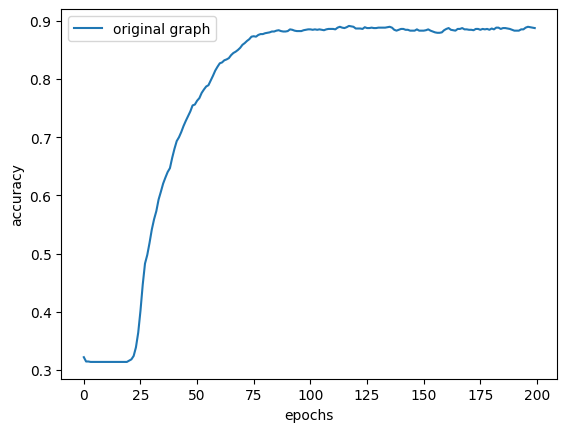

Median time per epoch: 0.01685810089111328s
Overall time: 3.639059066772461s
Best validation accuracy: 0.95


In [6]:
N_EPOCHS = 200

fg_model = GCN(num_features, 16, num_classes).to(device)
fg_criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
fg_optimizer = torch.optim.Adam(fg_model.parameters(), lr=0.01)  # Define optimizer.
fg_best_val_acc, fg_accs, fg_median_time_per_epoch, fg_overall_time = eval_model(fg_model, dataG, train_mask, test_mask, fg_optimizer,N_EPOCHS)
fig, ax = plt.subplots()

ax.plot(range(len(fg_accs)), fg_accs, label='original graph')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.show()

print(f"Median time per epoch: {fg_median_time_per_epoch}s")
print(f"Overall time: {fg_overall_time}s")
print(f"Best validation accuracy: {fg_best_val_acc:.2f}")


## Evaluating the model on the metric backbone of the Adamic-Adar weighted graph

In [7]:
print(f"{dataG.x.shape}")

torch.Size([2708, 1433])


Epoch: 001, Loss: 1.9465, Train: 0.2925, Test: 0.3109
Epoch: 010, Loss: 1.8146, Train: 0.2925, Test: 0.3124
Epoch: 020, Loss: 1.7004, Train: 0.2925, Test: 0.3117
Epoch: 030, Loss: 1.5696, Train: 0.3996, Test: 0.4106
Epoch: 040, Loss: 1.4201, Train: 0.5451, Test: 0.5185
Epoch: 050, Loss: 1.2384, Train: 0.6832, Test: 0.6677
Epoch: 060, Loss: 1.0966, Train: 0.7681, Test: 0.7238
Epoch: 070, Loss: 0.9052, Train: 0.8316, Test: 0.7939
Epoch: 080, Loss: 0.8181, Train: 0.8663, Test: 0.8383
Epoch: 090, Loss: 0.7210, Train: 0.8914, Test: 0.8626
Epoch: 100, Loss: 0.6460, Train: 0.9062, Test: 0.8700
Epoch: 110, Loss: 0.6164, Train: 0.9165, Test: 0.8722
Epoch: 120, Loss: 0.5506, Train: 0.9225, Test: 0.8759
Epoch: 130, Loss: 0.5238, Train: 0.9269, Test: 0.8796
Epoch: 140, Loss: 0.4544, Train: 0.9335, Test: 0.8804
Epoch: 150, Loss: 0.4413, Train: 0.9343, Test: 0.8789
Epoch: 160, Loss: 0.4283, Train: 0.9350, Test: 0.8759
Epoch: 170, Loss: 0.3813, Train: 0.9380, Test: 0.8752
Epoch: 180, Loss: 0.3715, Tr

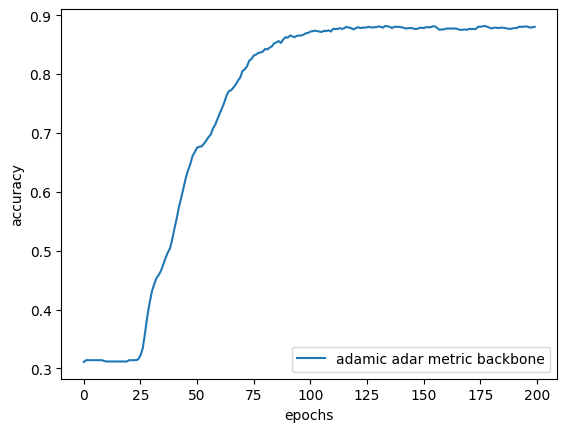

Median time per epoch: 0.018394947052001953s
Overall time: 3.7610020637512207s
Best accuracy: 0.94%


In [8]:
aa_model = GCN(num_features, 16, num_classes).to(device)
aa_criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
aa_optimizer = torch.optim.Adam(aa_model.parameters(), lr=0.01)  # Define optimizer.
aa_best_val_acc, aa_accs, aa_median_time_per_epoch, aa_overall_time = eval_model(aa_model, data_AdamicAdar_mb, train_mask, test_mask, aa_optimizer, N_EPOCHS)
aa_fig, aa_ax = plt.subplots()

aa_ax.plot(range(len(aa_accs)), aa_accs, label='adamic adar metric backbone')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.show()

print(f"Median time per epoch: {aa_median_time_per_epoch}s")
print(f"Overall time: {aa_overall_time}s")
print(f"Best accuracy: {aa_best_val_acc:.2f}%")

## Evaluating the model on the metric backbone of the Jaccard weighted graph

Epoch: 001, Loss: 1.9465, Train: 0.2932, Test: 0.3131
Epoch: 010, Loss: 1.8318, Train: 0.2939, Test: 0.3139
Epoch: 020, Loss: 1.7174, Train: 0.2939, Test: 0.3139
Epoch: 030, Loss: 1.5865, Train: 0.4668, Test: 0.4527
Epoch: 040, Loss: 1.4182, Train: 0.5687, Test: 0.5399
Epoch: 050, Loss: 1.2656, Train: 0.6536, Test: 0.6285
Epoch: 060, Loss: 1.0814, Train: 0.7422, Test: 0.7216
Epoch: 070, Loss: 0.9237, Train: 0.8220, Test: 0.7806
Epoch: 080, Loss: 0.8101, Train: 0.8685, Test: 0.8338
Epoch: 090, Loss: 0.6961, Train: 0.8944, Test: 0.8678
Epoch: 100, Loss: 0.6201, Train: 0.9084, Test: 0.8781
Epoch: 110, Loss: 0.5666, Train: 0.9136, Test: 0.8789
Epoch: 120, Loss: 0.5555, Train: 0.9210, Test: 0.8781
Epoch: 130, Loss: 0.4956, Train: 0.9239, Test: 0.8759
Epoch: 140, Loss: 0.4670, Train: 0.9291, Test: 0.8818
Epoch: 150, Loss: 0.4338, Train: 0.9313, Test: 0.8833
Epoch: 160, Loss: 0.4087, Train: 0.9357, Test: 0.8840
Epoch: 170, Loss: 0.3795, Train: 0.9402, Test: 0.8885
Epoch: 180, Loss: 0.3785, Tr

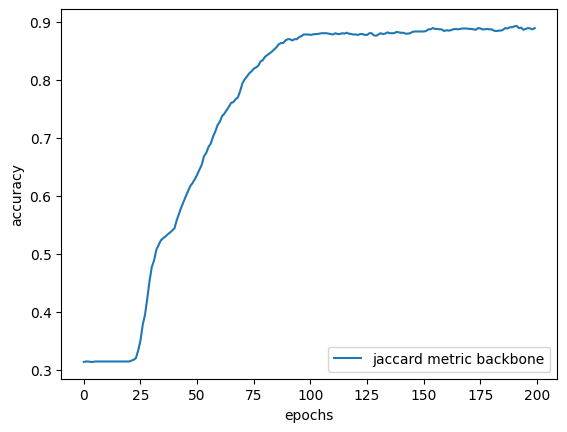

Median time per epoch: 0.01729297637939453s
Overall time: 3.5761940479278564s
Best accuracy: 0.94%


In [9]:
j_model = GCN(num_features, 16, num_classes).to(device)
j_criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
j_optimizer = torch.optim.Adam(j_model.parameters(), lr=0.01)  # Define optimizer.
j_best_val_acc, j_accs, j_median_time_per_epoch, j_overall_time = eval_model(j_model, data_Jaccard_mb, train_mask, test_mask, j_optimizer, N_EPOCHS)
j_fig, j_ax = plt.subplots()

j_ax.plot(range(len(j_accs)), j_accs, label='jaccard metric backbone')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.show()

print(f"Median time per epoch: {j_median_time_per_epoch}s")
print(f"Overall time: {j_overall_time}s")
print(f"Best accuracy: {j_best_val_acc:.2f}%")

## Plots

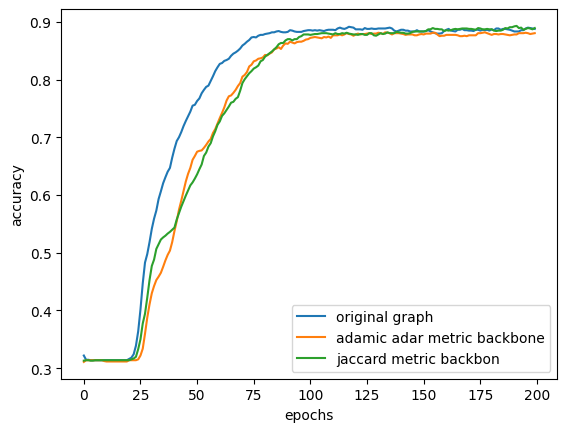

In [10]:
fig, ax = plt.subplots()
ax.plot(range(len(fg_accs)), fg_accs, label='original graph')
ax.plot(range(len(fg_accs)), aa_accs, label='adamic adar metric backbone')
ax.plot(range(len(fg_accs)), j_accs, label='jaccard metric backbon')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.show()
